<a href="https://colab.research.google.com/github/mrmolex/OpenVINO_DetectFaster_Chellenge/blob/main/301_tensorflow_training_openvino_trashclassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From Training to Deployment with TensorFlow and OpenVINO™

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Copyright 2018 The TensorFlow Authors
#
# Modified for OpenVINO Notebooks

This tutorial demonstrates how to train, convert, and deploy an image classification model with TensorFlow and OpenVINO. This particular notebook shows the process where we perform the inference step on the freshly trained model that is converted to OpenVINO IR with Model Optimizer. For faster inference speed on the model created in this notebook, check out the [Post-Training Quantization with TensorFlow Classification Model](./301-tensorflow-training-openvino-nncf.ipynb) notebook.


This training code comprises the official [TensorFlow Image Classification Tutorial](https://www.tensorflow.org/tutorials/images/classification) in its entirety.

The **flower_ir.bin** and **flower_ir.xml** (pre-trained models) can be obtained by executing the code with 'Runtime->Run All' or the Ctrl+F9 command.

## TensorFlow Image Classification Training

The first part of the tutorial shows how to classify images of flowers (based on the TensorFlow's official tutorial). It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model

## Import TensorFlow and Other Libraries

In [2]:
!pip install -q 'openvino-dev>=2023.0.0' 'nncf>=2.5.0'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.4/706.4 kB 65.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 kB 26.8 MB/s eta 0:00:00


In [3]:
from pathlib import Path

# Fetch the notebook utils script from the openvino_notebooks repo
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

from notebook_utils import download_file, VideoPlayer

In [4]:
import os
import sys
#from pathlib import Path

import PIL
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from openvino.runtime import Core
from openvino.tools import mo
from openvino.runtime import serialize
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

sys.path.append("../utils")
from notebook_utils import download_file

## Download and Explore the Dataset

This tutorial uses a dataset of about 3,870 photos of trash elements. The dataset contains 4 sub-directories, one per class:

```
DataSet_V3/
  cup/
  biological/
  paper/
  plastic/
```

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.mkdir('./content')

In [11]:
!unzip "/content/drive/MyDrive/Personal/Especializacion/Dataset/DataSet_V3.zip" -d "/content/content"

Archive:  /content/drive/MyDrive/Personal/Especializacion/Dataset/DataSet_V3.zip
   creating: /content/content/DataSet_V3/
   creating: /content/content/DataSet_V3/biological/
  inflating: /content/content/DataSet_V3/biological/biological1.jpg  
  inflating: /content/content/DataSet_V3/biological/biological10.jpg  
  inflating: /content/content/DataSet_V3/biological/biological100.jpg  
  inflating: /content/content/DataSet_V3/biological/biological101.jpg  
  inflating: /content/content/DataSet_V3/biological/biological102.jpg  
  inflating: /content/content/DataSet_V3/biological/biological103.jpg  
  inflating: /content/content/DataSet_V3/biological/biological104.jpg  
  inflating: /content/content/DataSet_V3/biological/biological105.jpg  
  inflating: /content/content/DataSet_V3/biological/biological106.jpg  
  inflating: /content/content/DataSet_V3/biological/biological107.jpg  
  inflating: /content/content/DataSet_V3/biological/biological108.jpg  
  inflating: /content/content/DataS

In [12]:
import pathlib
data_dir = '/content/content/DataSet_V3'
data_dir = pathlib.Path(data_dir)

In [ ]:
#import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
#data_dir = pathlib.Path(data_dir)

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [13]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3868


Here are some roses:

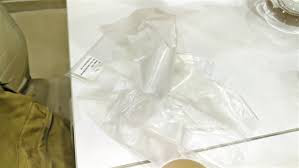

In [15]:
plastic = list(data_dir.glob('plastic/*'))
PIL.Image.open(str(plastic[0]))

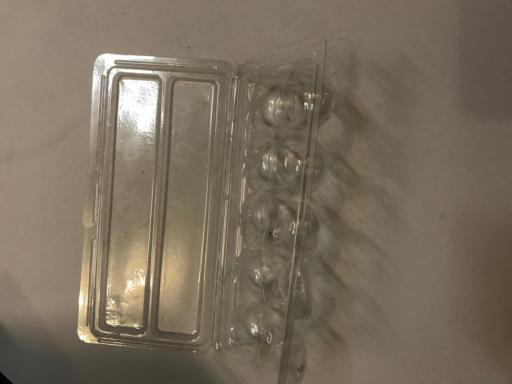

In [16]:
PIL.Image.open(str(plastic[1]))

And some cups:

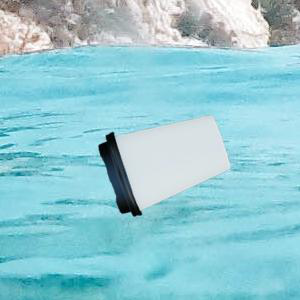

In [18]:
cup = list(data_dir.glob('cup/*'))
PIL.Image.open(str(cup[0]))

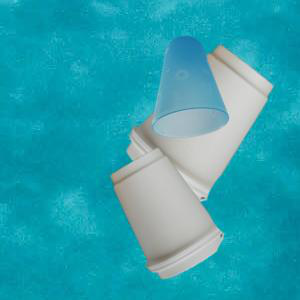

In [19]:
PIL.Image.open(str(cup[1]))

## Load Using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a Dataset

Define some parameters for the loader:

In [20]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [21]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 4 classes.
Using 3095 files for training.


In [22]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 4 classes.
Using 773 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [23]:
class_names = train_ds.class_names
print(class_names)

['biological', 'cup', 'paper', 'plastic']


## Visualize the Data

Here are the first 9 images from the training dataset.

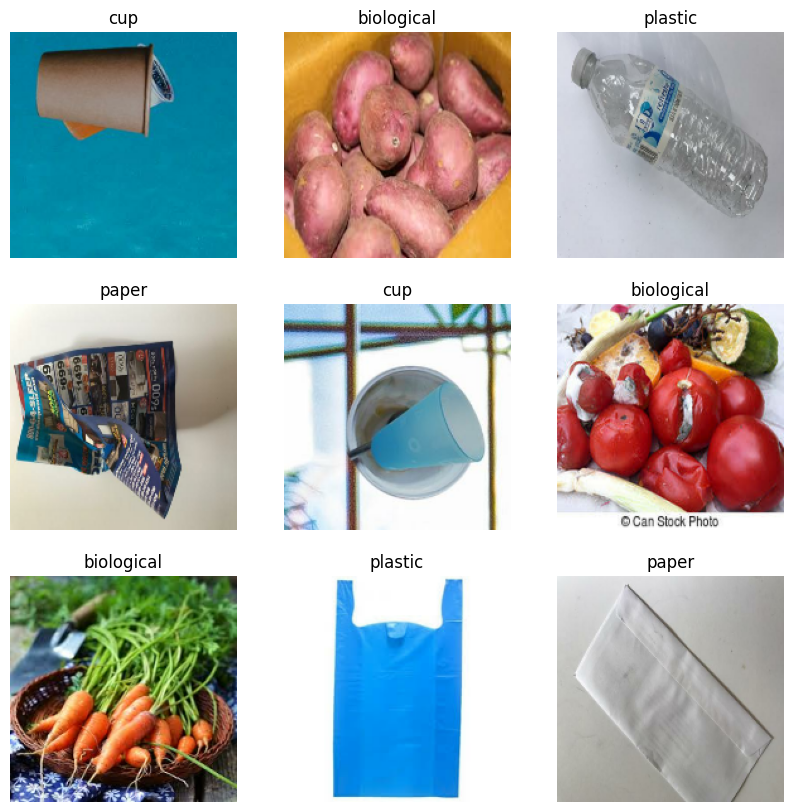

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [25]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the Dataset for Performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [26]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the Data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [27]:
normalization_layer = layers.Rescaling(1./255)

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [28]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

## Create the Model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach.

In [29]:
num_classes = 4

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the Model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Summary

View all the layers of the network using the model's `summary` method.

> **NOTE:** This section is commented out for performance reasons. Please feel free to uncomment these to compare the results.

In [31]:
 model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Train the Model

In [34]:
 epochs=20
 history = model.fit(
   train_ds,
   validation_data=val_ds,
   epochs=epochs
 )

Epoch 1/20
97/97 [==============================] - 3s 29ms/step - loss: 0.0434 - accuracy: 0.9858 - val_loss: 0.8086 - val_accuracy: 0.8305
Epoch 2/20
97/97 [==============================] - 2s 24ms/step - loss: 0.0416 - accuracy: 0.9877 - val_loss: 0.7710 - val_accuracy: 0.8473
Epoch 3/20
97/97 [==============================] - 2s 21ms/step - loss: 0.0403 - accuracy: 0.9887 - val_loss: 0.7526 - val_accuracy: 0.8551
Epoch 4/20
97/97 [==============================] - 2s 21ms/step - loss: 0.0234 - accuracy: 0.9932 - val_loss: 0.9973 - val_accuracy: 0.8215
Epoch 5/20
97/97 [==============================] - 2s 21ms/step - loss: 0.0748 - accuracy: 0.9725 - val_loss: 0.7707 - val_accuracy: 0.8137
Epoch 6/20
97/97 [==============================] - 2s 21ms/step - loss: 0.0158 - accuracy: 0.9968 - val_loss: 0.9783 - val_accuracy: 0.8370
Epoch 7/20
97/97 [==============================] - 2s 21ms/step - loss: 0.0218 - accuracy: 0.9939 - val_loss: 0.7757 - val_accuracy: 0.8655
Epoch 8/20
97

## Visualize Training Results

Create plots of loss and accuracy on the training and validation sets.

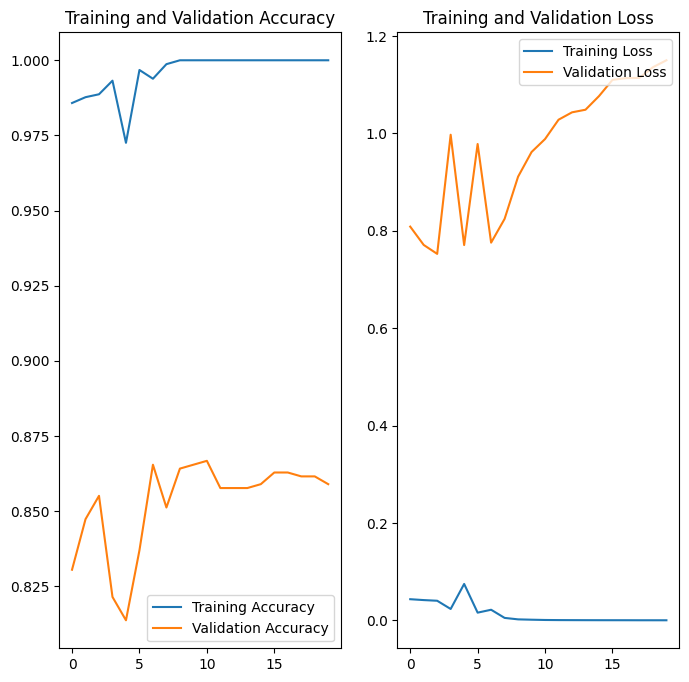

In [35]:
 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']

 loss = history.history['loss']
 val_loss = history.history['val_loss']

 epochs_range = range(epochs)

 plt.figure(figsize=(8, 8))
 plt.subplot(1, 2, 1)
 plt.plot(epochs_range, acc, label='Training Accuracy')
 plt.plot(epochs_range, val_acc, label='Validation Accuracy')
 plt.legend(loc='lower right')
 plt.title('Training and Validation Accuracy')

 plt.subplot(1, 2, 2)
 plt.plot(epochs_range, loss, label='Training Loss')
 plt.plot(epochs_range, val_loss, label='Validation Loss')
 plt.legend(loc='upper right')
 plt.title('Training and Validation Loss')
 plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around XXX% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable — a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data Augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside your model like other layers, and run on the GPU.

In [36]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                   img_width,
                                   3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

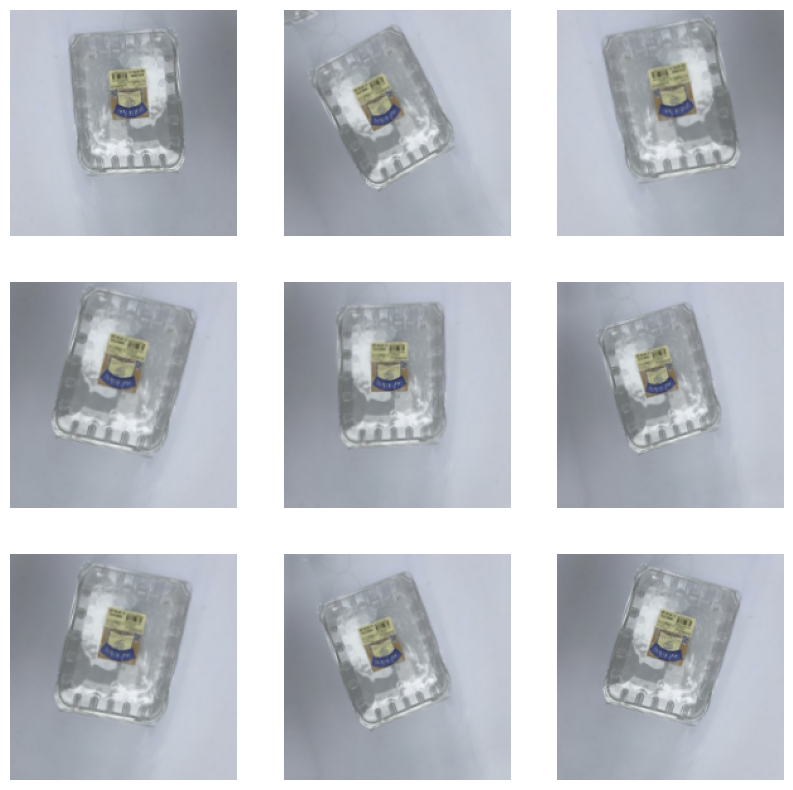

In [37]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [38]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

## Compile and Train the Model

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [41]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
97/97 [==============================] - 5s 32ms/step - loss: 1.0021 - accuracy: 0.5919 - val_loss: 0.8500 - val_accuracy: 0.7038
Epoch 2/15
97/97 [==============================] - 3s 30ms/step - loss: 0.7320 - accuracy: 0.7076 - val_loss: 1.0283 - val_accuracy: 0.6326
Epoch 3/15
97/97 [==============================] - 3s 34ms/step - loss: 0.6263 - accuracy: 0.7635 - val_loss: 0.7379 - val_accuracy: 0.7232
Epoch 4/15
97/97 [==============================] - 3s 30ms/step - loss: 0.5932 - accuracy: 0.7670 - val_loss: 0.5880 - val_accuracy: 0.7956
Epoch 5/15
97/97 [==============================] - 3s 30ms/step - loss: 0.5544 - accuracy: 0.7858 - val_loss: 0.6143 - val_accuracy: 0.7814
Epoch 6/15
97/97 [==============================] - 3s 30ms/step - loss: 0.5064 - accuracy: 0.8055 - val_loss: 0.6294 - val_accuracy: 0.7891
Epoch 7/15
97/97 [==============================] - 3s 31ms/step - loss: 0.4634 - accuracy: 0.8258 - val_loss: 0.5979 - val_accuracy: 0.7982
Epoch 8/15
97

## Visualize Training Results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned.

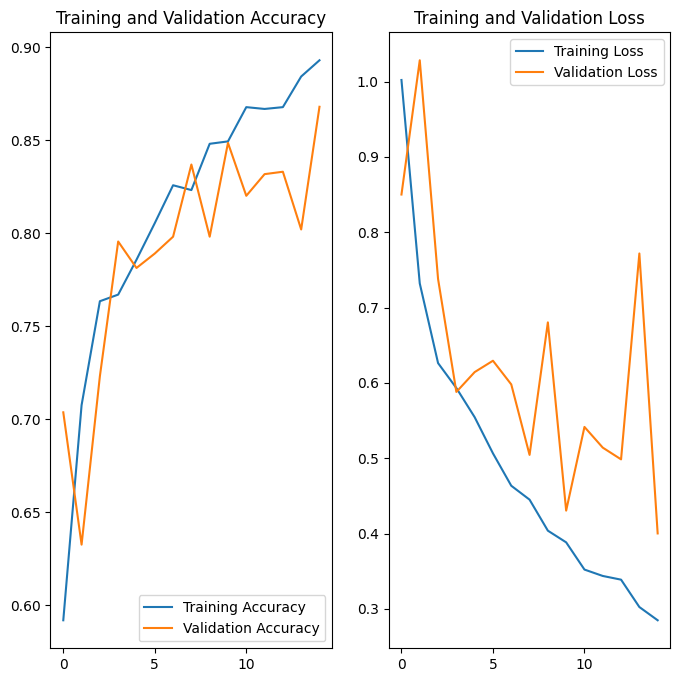

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on New Data

Finally, let us use the model to classify an image that was not included in the training or validation sets.

> **Note**: Data augmentation and Dropout layers are inactive at inference time.

In [45]:
cup_url = "https://cdn.britannica.com/25/93825-050-D1300547/collection-newspapers.jpg"
cup_path = tf.keras.utils.get_file('PapperCupTest', origin=cup_url)

img = keras.preprocessing.image.load_img(
    cup_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to paper with a 98.35 percent confidence.


## Save the TensorFlow Model

In [46]:
#save the trained model - a new folder flower will be created
#and the file "saved_model.pb" is the pre-trained model
model_dir = "model"
saved_model_dir = f"{model_dir}/trashcan/saved_model"
model.save(saved_model_dir)

## Convert the TensorFlow model with OpenVINO Model Optimizer
Use Model Optimizer Python API to convert the model to OpenVINO IR with `FP16` precision. For more information about Model Optimizer Python API, see the [Model Optimizer Developer Guide](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_Python_API.html).

In [47]:
# Convert the model to ir model format and save it.
ir_model_path = Path("model/trashcan")
ir_model_path.mkdir(parents=True, exist_ok=True)
ir_model = mo.convert_model(saved_model_dir=saved_model_dir, input_shape=[1,180,180,3], compress_to_fp16=True)
serialize(ir_model, str(ir_model_path / "trashcan_ir.xml"))

## Preprocessing Image Function

In [48]:
def pre_process_image(imagePath, img_height=180):
    # Model input format
    n, h, w, c = [1, img_height, img_height, 3]
    image = Image.open(imagePath)
    image = image.resize((h, w), resample=Image.BILINEAR)

    # Convert to array and change data layout from HWC to CHW
    image = np.array(image)
    input_image = image.reshape((n, h, w, c))

    return input_image

## OpenVINO Inference Engine Setup

In [50]:
class_names=["cup", "papper", "plastic", "biological"]

# Initialize OpenVINO runtime
ie = Core()

# Neural Compute Stick
# compile the model for the CPU (you can choose manually CPU, GPU, MYRIAD etc.)
# or let the engine choose the best available device (AUTO)
# compiled_model = ie.compile_model(model=model, device_name="MYRIAD")
compiled_model = ie.compile_model(model=ir_model, device_name="CPU")

del ir_model

input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

## Run the Inference Step

output/plastic_waste.jpg:   0%|          | 0.00/170k [00:00<?, ?B/s]

(1, 180, 180, 3)
[1,180,180,3]
This image most likely belongs to plastic with a 47.30 percent confidence.


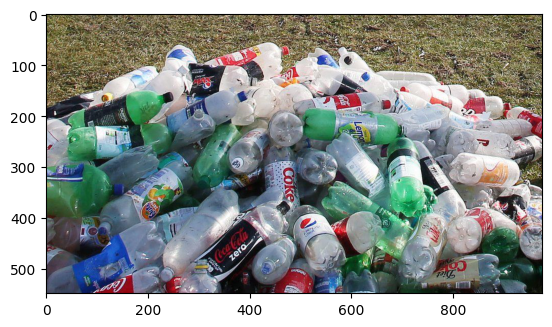

In [53]:
# Run inference on the input image...
inp_img_url = "https://ichef.bbci.co.uk/news/976/cpsprodpb/4487/production/_99734571_044251984-1.jpg"
OUTPUT_DIR = "output"
inp_file_name = f"plastic_waste.jpg"
file_path = Path(OUTPUT_DIR)/Path(inp_file_name)

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Download the image
download_file(inp_img_url, inp_file_name, directory=OUTPUT_DIR)

# Pre-process the image and get it ready for inference.
input_image = pre_process_image(file_path)

print(input_image.shape)
print(input_layer.shape)
res = compiled_model([input_image])[output_layer]

score = tf.nn.softmax(res[0])

# Show the results
image = Image.open(file_path)
plt.imshow(image)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

## The Next Steps

This tutorial showed how to train a TensorFlow model, how to convert that model to OpenVINO's IR format, and how to do inference on the converted model. For faster inference speed, you can quantize the IR model. To see how to quantize this model with OpenVINO's [Post-training Quantization with NNCF Tool](https://docs.openvino.ai/nightly/basic_quantization_flow.html), check out the [Post-Training Quantization with TensorFlow Classification Model](./301-tensorflow-training-openvino-nncf.ipynb) notebook.